# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [22]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [23]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

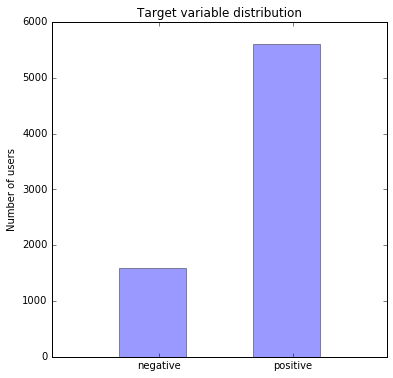

In [24]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [25]:
CONSUMER_KEY = "pEeYvgCsR5cOnxu0LXgNEbSbh"
CONSUMER_SECRET = "XTVthLigui9TioOkINuW28wBHJ8XVtAJVrmOKZZXqR91BUzES3"

ACCESS_TOKEN_KEY = "159127782-PeTXoGSz4xJBzYBJ2x3M5rIGuLXV8fOJ6cQgmHBS"
ACCESS_TOKEN_SECRET = "tW5BG5ktDzFlkz921eFKR95zre21oR9nvIyTKSWDE5yYm"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [37]:
GEO_USER_NAME = "DronVol"
Locations_Base = {}

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name"
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    # your code here
    
    global Locations_Base
    lat  = None # latitude
    lng  = None # longitude
    countryName = None
    
    if location != None:
        countryName = unicode(location) 
        # save fiction location like this:
    else: return None,None,None
    
    url  = "http://api.geonames.org/searchJSON"
    
    if location in Locations_Base:
        return Locations_Base[location]["lat"], Locations_Base[location]["lng"], Locations_Base[location]["countryName"]
    
    #request parameters are in req_par
    req_par = dict(
        q = location,
        maxRows = "1",
        username = GEO_USER_NAME
    )
    

    req = requests.get(url=url, params=req_par)
    data = json.loads(req.text)
    
    if 'geonames' in data and len(data['geonames']):
        lat = float(data['geonames'][0]['lat']) 
        lng = float(data['geonames'][0]['lng']) 
        if 'countryName' in data['geonames'][0]:
            countryName = data['geonames'][0]['countryName']
        else:
            countryName = data['geonames'][0]['name']
    Locations_Base[location] = {"lat":lat, "lng":lng, "countryName":countryName}
    return lat, lng, countryName

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [60]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record

def get_user_records(df):
    # your code here
    # some_downloaded_user = get_user_from_api
    # also write user as json line in temporary file
    # return [twitter_user_to_dataframe_record(some_downloaded_user)]
    
    global user_records
    global time
    all_users = df["uid"].values.tolist()
    id_list = [record["uid"] for record in user_records]
    for uid in id_list: all_users.remove(uid)
        
    for n in range(0, len(all_users), 100):
        user_ids = all_users[n:n+100]
        check = False
        while not check:
            try:
                user_list = api.UsersLookup(user_id=user_ids)
                for user in user_list:
                    new_user = twitter_user_to_dataframe_record(user)
                    f.write(json.dumps(new_user)+'\n')
                    user_records.append(new_user)
                check = True
                perc=len(user_records)*100/len(all_users)
                print "Downloaded %.2f%c"%(perc,'%')
           
            except twitter.TwitterError, e: #Twitter requests overflow
                if e.args[0][0]["code"] == 88:
                    print "Twitter API limit 15 min"
                    for i in range(2,11,2):
                        time.sleep(180)
                        print "%d% completed;"%(i*10)
                else:
                    print "Continue"
                    check = True
                
                
            
    return user_records

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)
f.close()
        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

4510
7505
Downloaded 60.00%
4610
7505
Downloaded 61.00%
4709
7505
Downloaded 62.00%
4808
7505
Downloaded 64.00%
4908
7505
Downloaded 65.00%
5006
7505
Downloaded 66.00%
5105
7505
Downloaded 68.00%
5204
7505
Downloaded 69.00%
5304
7505
Downloaded 70.00%
5403
7505
Downloaded 71.00%
5503
7505
Downloaded 73.00%
5602
7505
Downloaded 74.00%
5702
7505
Downloaded 75.00%
5801
7505
Downloaded 77.00%
5900
7505
Downloaded 78.00%
6000
7505
Downloaded 79.00%
6100
7505
Downloaded 81.00%
6199
7505
Downloaded 82.00%
6298
7505
Downloaded 83.00%
6395
7505
Downloaded 85.00%
6493
7505
Downloaded 86.00%
6592
7505
Downloaded 87.00%
6692
7505
Downloaded 89.00%
6792
7505
Downloaded 90.00%
6891
7505
Downloaded 91.00%
6991
7505
Downloaded 93.00%
7090
7505
Downloaded 94.00%
7189
7505
Downloaded 95.00%
7276
7505
Downloaded 96.00%
7364
7505
Downloaded 98.00%
7458
7505
Downloaded 99.00%
7548
7505
Downloaded 100.00%
7638
7505
Downloaded 101.00%
7725
7505
Downloaded 102.00%
7822
7505
Downloaded 104.00%
7911
7505
Downlo

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

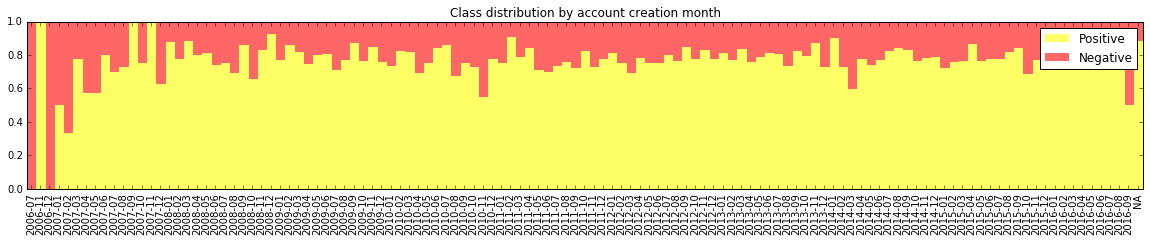

In [113]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    # your code here 
    index = 0
    for user_group in grouped:
        dts.append(user_group[0])
        for a in user_group[1]["cls"].values:
            if a == 1.0: count_pos[index] += 1
            if a == 0.0: count_neg[index] += 1
        index += 1
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='yellow', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

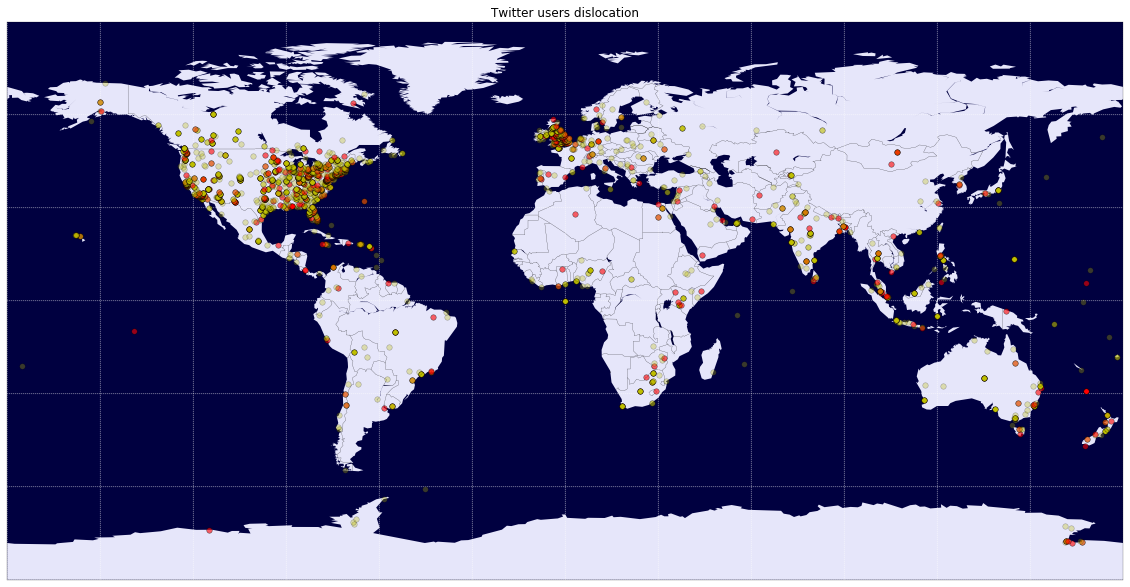

In [114]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map. Be creative.
    """
    # your code here
    grouped_for_map = df_full.groupby(map(lambda dt: dt, df_full[["lat","lon","cls"]]))
    
    for user_group in grouped_for_map:
        #координаты
        lat = user_group[0][0]
        lon = user_group[0][1]  
        
        yellow = 0
        red = 0
        
        for a in user_group[1]["cls"].values:
            if a == 1.0: yellow += 1
        for b in user_group[1]["cls"].values:
            if b == 0.0: red += 1
        
        if red > 0: 
            color = 'ro' 
            transparency = red * 0.6
            if transparency > 1: transparency = 1
            m.plot(lon, lat,  color, alpha = transparency, markersize=5.5)
            
        if yellow > 0: 
            color = 'yo' 
            transparency = yellow * 0.3
            if transparency > 1: transparency = 1
            m.plot(lon, lat,  color, alpha = transparency, markersize=5.5)
            
    return

plot_points_on_map(df_full)

pl.title("Twitter users dislocation")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* прозрачность точки меняется в зависимости от количества пользователей

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

Negative class users:
 min = 0; 	 max = 590467; 	 median = 378; 	 mean = 3278;
Positive class users:
 min = 0; 	 max = 294373; 	 median = 353; 	 mean = 2686.


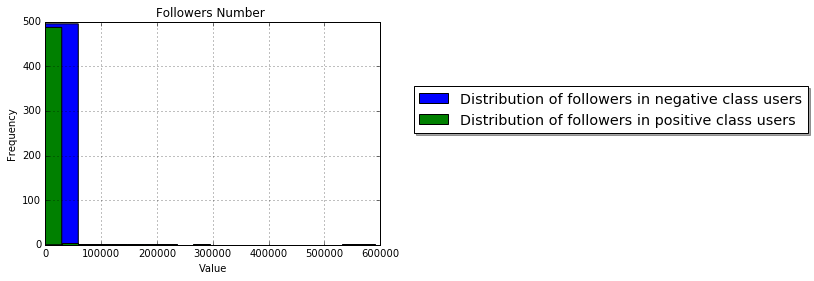

In [119]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
        #Calculate min max and median. Plot histogram
        #Your code here
    print "Negative class users:\n min = %d; \t max = %d; \t median = %d; \t mean = %d;"%(
        users_wth_neg_class['followers_count'].min(),
        users_wth_neg_class['followers_count'].max(),
        users_wth_neg_class['followers_count'].median(),
        users_wth_neg_class['followers_count'].mean())
    print "Positive class users:\n min = %d; \t max = %d; \t median = %d; \t mean = %d."%(
        users_wth_pos_class['followers_count'].min(),
        users_wth_pos_class['followers_count'].max(),
        users_wth_pos_class['followers_count'].median(),
        users_wth_pos_class['followers_count'].mean())
    
    users_wth_neg_class['followers_count'].hist(label = "Distribution of followers in negative class users")
    users_wth_pos_class['followers_count'].hist(label = "Distribution of followers in positive class users")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Followers Number ')
    plt.legend(loc = (1.1,0.5), shadow=True, fontsize='x-large')
    return
descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)

# Смотрим на полученный data frame и сохраняем его в .csv файл.

In [65]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76,-98.5,United States,2009-05,7623,4285,50630,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1909,1240,7130,128,96
2,3314758074,0,Campaign Trump,Campaign_Trump,Moving on to Super Tuesday. Indp. Local & Inte...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,16396,12156,695,6824,146
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1754,1292,7325,157,112
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1466,1187,37043,3303,78
